In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS
from graphviz import Digraph

import zipfile

List of Causal Effects:

Earth quake affects monetary policy https://www.sciencedirect.com/science/article/pii/S0164070418304026

Dynamics of Tokyo Electric Power Company and the Nikkei https://www.jstor.org/stable/26418774

Global Seismic Data: https://www.globalquakemodel.org/product/global-seismic-hazard-map

Global Earthquake Exposure Model (Data for exposure model): https://github.com/gem/global_exposure_model

Global Earthquake Vulnerability Model (Data for vulnerability model): https://github.com/gem/global_vulnerability_model/

Japanese Municipal Bonds (quarterly): https://needs.nikkei.co.jp/services/jsprice/#sample

Japanese Municipal Bonds (daily): https://www.mcnnns77.net/market-data

Mesh code and prefectures: https://www.stat.go.jp/data/mesh/m_itiran.html

Earthquake probability (Seismic Hazard Map): https://www.j-shis.bosai.go.jp/map/JSHIS2/download.html?lang=en (first four columns)

Earthquake probability documentation:
- https://www.j-shis.bosai.go.jp/map/JSHIS2/man/en/man_point_search.html
- https://www.j-shis.bosai.go.jp/map/JSHIS2/man/en/man_map_operation_c.html

How to calculate latitude and longitude from MeshCode (documentation in Japanese):
- https://www.stat.go.jp/data/mesh/pdf/gaiyo1.pdf#page=7

Total number of bond issued from 2002 for each city per year:
- https://www.soumu.go.jp/iken/kessan_jokyo_2.html

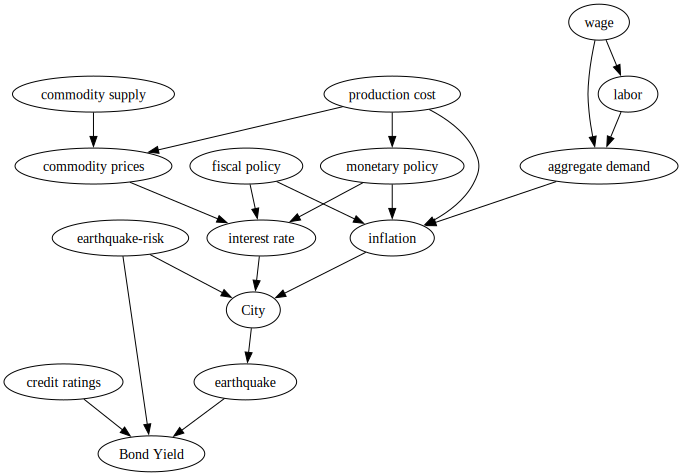

In [2]:
## TODO: make changes to the DAG
g = Digraph()
g.edge("interest rate", "City")
g.edge("inflation", "City")
g.edge("credit ratings", "Bond Yield")
g.edge("production cost", "inflation")
g.edge("aggregate demand", "inflation")
g.edge("wage", "aggregate demand")
g.edge("wage", "labor")
g.edge("labor", "aggregate demand")
g.edge("monetary policy", "interest rate")
g.edge("fiscal policy", "interest rate")
g.edge("production cost", "monetary policy")
g.edge("earthquake-risk", "City")
g.edge("earthquake-risk", "Bond Yield")
g.edge("commodity supply", "commodity prices")
g.edge("production cost", "commodity prices")
g.edge("commodity prices", "interest rate")
g.edge("monetary policy", "inflation")
g.edge("fiscal policy", "inflation")
g.edge("City","earthquake")
g.edge("earthquake", "Bond Yield")
g

In [3]:
earthquake_data = pd.read_csv("data/world_eq_info.csv")
earthquake_data = earthquake_data[earthquake_data['Country'] == 'Japan']
print(earthquake_data.columns)
earthquake_data.head()

Index(['Event_ID', 'Year', 'Country', 'Region', 'Event_Name', 'Local_Date',
       'Local_Time', 'Latitude', 'Longitude', 'Depth_(km)', 'Mw',
       'Max_Intensity_(MMI)', 'Fault_mechanism', 'Tectonic_region_type',
       'Fatalities', 'Injured', 'Displaced_Population', 'Affected_Population',
       'Affected_Units', 'Damaged_Units', 'Collapsed_Units', 'Economic_Losses',
       'Insured_Losses', 'Induced_Effects', 'USGS page', 'Wikipedia page',
       'Destroyed_Units', 'Homeless'],
      dtype='object')


,Event_ID,Year,Country,Region,Event_Name,Local_Date,Local_Time,Latitude,Longitude,Depth_(km),...,Affected_Units,Damaged_Units,Collapsed_Units,Economic_Losses,Insured_Losses,Induced_Effects,USGS page,Wikipedia page,Destroyed_Units,Homeless
8,20190618_M6.4_Yamagata,2019,Japan,Yamagata,Yamagata_2019,18/06/2019,22:22:20,38.6390,139.4770,12.0,...,NaN,144-1608 Buildings,NaN,NaN,NaN,Tsunami,https://earthquake.usgs.gov/earthquakes/eventp...,https://en.wikipedia.org/wiki/2019_Yamagata_ea...,NaN,NaN
10,20180618_M5.5_Osaka,2018,Japan,Osaka,Osaka_2018,18/06/2018,07:58:35,34.8250,135.6390,10.3,...,NaN,6766-8086 Units,3 Units,3250-7000 M USD,NaN,"Landslide, Fire",https://earthquake.usgs.gov/earthquakes/eventp...,https://en.wikipedia.org/wiki/2018_Osaka_earth...,NaN,NaN
11,20180906_M6.6_HokkaidoEasternIburi,2018,Japan,Hokkaido,HokkaidoEasternIburi_2018,06/09/2018,03:08:58,42.6860,141.9290,35.0,...,NaN,14170-15000 Units,462 Units,1250-2000 M USD,NaN,"Landslides, Debris flows, fires",https://earthquake.usgs.gov/earthquakes/eventp...,https://en.wikipedia.org/wiki/2018_Hokkaido_Ea...,NaN,NaN
22,20160416_M7.0_Kumamoto,2016,Japan,Kumamoto,Kumamoto_2016,16/04/2016,01:25:06,32.7906,130.7543,10.0,...,198636 Units,189939 Units,8697 Units,20000-22580 M USD,5000-5645 M USD,"Landslides, Debris flows, Cliff failures",https://earthquake.usgs.gov/earthquakes/eventp...,https://en.wikipedia.org/wiki/2016_Kumamoto_ea...,NaN,NaN
43,20110311_M9.1_Tohoku,2011,Japan,Tōhoku,Tōhoku_2011,11/03/2011,14:46:18,38.2970,142.3730,29.0,...,>332395,144300-280920,121778-400000,169000-309000 M USD,37500 M USD,Tsunami,https://earthquake.usgs.gov/earthquakes/eventp...,https://en.wikipedia.org/wiki/2011_Tōhoku_eart...,NaN,NaN


In [4]:
# Specify the path to your zip file and the name of the CSV file within the zip file
FILENAME = "P-Y2010-MAP-AVR-TTL_MTTL"
COLUMNS = ['# CODE', ' T30_I45_PS', ' T30_I50_PS', ' T30_I55_PS', ' T30_I60_PS']
zip_file_path = 'data/' + FILENAME + '.zip'
csv_file_name = FILENAME + '.csv'
rows_to_skip = 8

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file
    with zip_ref.open(csv_file_name) as file:
        # Read the CSV file into a DataFrame
        seismic_data = pd.read_csv(file, skiprows = rows_to_skip)[COLUMNS]
seismic_data.head()

,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS
0,3036500524N,0.000000,0.000000,0.000000,0.000000
1,3036500542N,0.000000,0.000000,0.000000,0.000000
2,3036500623N,0.000000,0.000000,0.000000,0.000000
3,3036500641N,0.000000,0.000000,0.000000,0.000000
4,3622572534N,0.797367,0.454856,0.176731,0.034857


In [62]:
# # TODO: check this is correct

# def get_latlon(meshCode):

#     #Convert to string
#     meshCode = str(meshCode)

#     #Calculation for primary mesh
#     code_first_two = meshCode[0:2]
#     code_last_two = meshCode[2:4]
#     code_first_two = int(code_first_two)
#     code_last_two = int(code_last_two)
#     lat  = code_first_two * 2 / 3
#     lon = code_last_two + 100

#     if len(meshCode) > 4:
#         #Calculation for secondary mesh
#         if len(meshCode) >= 6:
#             code_fifth = meshCode[4:5]
#             code_sixth = meshCode[5:6]
#             code_fifth = int(code_fifth)
#             code_sixth = int(code_sixth)
#             lat += code_fifth * 2 / 3 / 8
#             lon += code_sixth / 8

#         #Calculation for 3rd mesh
#         if len(meshCode) >= 8:
#             code_seventh = meshCode[6:7]
#             code_eighth = meshCode[7:8]
#             code_seventh = int(code_seventh)
#             code_eighth = int(code_eighth)
#             lat += code_seventh * 2 / 3 / 8 / 10
#             lon += code_eighth / 8 / 10
            
#         # 1/Calculation for 2 mesh
#         if len(meshCode) >= 9:
#             code_nineth = meshCode[8:9]
#             code_nineth = int(code_nineth)
#             if code_nineth % 2 == 0:
#                 lon += 0.00138888
#             if code_nineth > 2:
#                 lat += 0.00416666
                
#         # 1/Calculation for 4 mesh
#         if len(meshCode) >= 10:
#             code_tenth = meshCode[9:10]
#             code_tenth = int(code_tenth)
#             if code_tenth % 2 == 0:
#                 lon += 0.00138888 / 2
#             if code_tenth > 2:
#                 lat += 0.00416666 / 2
        
#         # 1/Calculation for 8 mesh
#         if len(meshCode) >= 11:
#             code_eleventh = meshCode[10:11]
#             code_eleventh = int(code_eleventh)
#             if code_eleventh % 2 == 0:
#                 lon += 0.00138888 / 2 / 2
#             if code_eleventh > 2:
#                 lat += 0.00416666 / 2 / 2
            
#     return lat, lon
# seismic_data["lat"] = seismic_data[COLUMNS[0]].apply(lambda x: get_latlon(x[:-1])[0])
# seismic_data["lon"] = seismic_data[COLUMNS[0]].apply(lambda x: get_latlon(x[:-1])[1])
# get_latlon(seismic_data[COLUMNS[0]][:-1])[1]
# seismic_data["lon"] = get_latlon(seismic_data[COLUMNS[0]][:-1])[0]
# seismic_data.head()

In [5]:
MESHCODE = "MeshCode"
prefecture_for_mesh = [
    "Hokkaido",
    "Aomori",
    "Iwate",
    "Miyagi",
    "Akita",
    "Yamagata",
    "Fukushima",
    "Ibaraki",
    "Tochigi",
    "Gunma",
    "Saitama",
    "Chiba",
    "Tokyo",
    "Kanagawa",
    "Niigata",
    "Toyama",
    "Ishikawa",
    "Fukui",
    "Yamanashi",
    "Nagano",
    "Gifu",
    "Shizuoka",
    "Aichi",
    "Mie",
    "Shiga",
    "Kyoto",
    "Osaka",
    "Hyogo",
    "Nara",
    "Wakayama",
    "Tottori",
    "Shimane",
    "Okayama",
    "Hiroshima",
    "Yamaguchi",
    "Tokushima",
    "Kagawa",
    "Ehime",
    "Kochi",
    "Fukuoka",
    "Saga",
    "Nagasaki",
    "Kumamoto",
    "Oita",
    "Miyazaki",
    "Kagoshima",
    "Okinawa"
]

unique_mesh_codes = {}
earthquake_risks = {}
total_sum = 0
for prefecture in prefecture_for_mesh:
    unique_mesh_codes[prefecture] = set(pd.read_csv("data/" + prefecture + "Mesh.csv")[MESHCODE].unique())
    seismic_data["in"+prefecture] = seismic_data[COLUMNS[0]].astype(str).str[:8].astype(int).isin(unique_mesh_codes[prefecture]).astype(int)
    earthquake_risks[prefecture] = seismic_data.query(f"in{prefecture} == 1")
    total_sum += len(earthquake_risks[prefecture])


In [6]:
prefecture_for_bond = ["Fukushima", "Hokkaido", "Osaka", "Kumamoto", "Fukuoka", "Kanagawa", "Hyogo", "Miyagi", "Niigata", "Aichi",
                        "Chiba", "Saitama", "Shizuoka", "Fukui", "Gifu", "Gunma", "Ibaraki", "Mie", "Nagano", "Tochigi", "Tokyo",
                        "Yamanashi", "Kyoto", "Nara", "Shiga", "Hiroshima", "Okayama", "Kagoshima", "Kochi", "Nagasaki", "Oita",
                        "Saga", "Shimane", "Tokushima", "Akita"]
bond_data = {}
panel_data = pd.DataFrame()

risk_column_names = seismic_data.columns[1:5]

for prefecture in prefecture_for_bond:
    bond_data[prefecture] = pd.read_csv("data/"+prefecture+".csv")
    bond_data[prefecture]['Date'] = pd.to_datetime(bond_data[prefecture]['Date'], unit='s')
    bond_data[prefecture]['Date'] = bond_data[prefecture]['Date'].dt.strftime('%Y/%m/%d')
    bond_data[prefecture]['Prefecture'] = prefecture
    for column in risk_column_names:
        bond_data[prefecture][column] = earthquake_risks[prefecture][column].mean()
    panel_data = panel_data.append(bond_data[prefecture], ignore_index=True)
    # print(prefecture+":")
    # print(bond_data[prefecture].tail())
    # print("="*55)
panel_data

/var/folders/10/5x4xh59n17s1y177g8ms9sc40000gn/T/ipykernel_995/2442989839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panel_data = panel_data.append(bond_data[prefecture], ignore_index=True)
/var/folders/10/5x4xh59n17s1y177g8ms9sc40000gn/T/ipykernel_995/2442989839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panel_data = panel_data.append(bond_data[prefecture], ignore_index=True)
/var/folders/10/5x4xh59n17s1y177g8ms9sc40000gn/T/ipykernel_995/2442989839.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  panel_data = panel_data.append(bond_data[prefecture], ignore_index=True)
/var/folders/10/5x4xh59n17s1y177g8ms9sc40000gn/T/ipykernel_995/2442989839.py:17: FutureWarning: The frame.append method is deprecated

,Date,3 Year,5 Year,7 Year,10 Year,15 Year,20 Year,Prefecture,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS
0,2008/03/25,0.009841,0.009718,NaN,NaN,NaN,NaN,Fukushima,0.282983,0.062181,0.008838,0.000647
1,2008/03/26,0.009944,0.009716,NaN,NaN,NaN,NaN,Fukushima,0.282983,0.062181,0.008838,0.000647
2,2008/03/27,0.00993,0.009596,NaN,NaN,NaN,NaN,Fukushima,0.282983,0.062181,0.008838,0.000647
3,2008/03/28,0.009799,0.00955,NaN,NaN,NaN,NaN,Fukushima,0.282983,0.062181,0.008838,0.000647
4,2008/03/31,0.009808,0.009531,NaN,NaN,NaN,NaN,Fukushima,0.282983,0.062181,0.008838,0.000647
...,...,...,...,...,...,...,...,...,...,...,...,...
179592,2023/10/25,0.002482,0.004579,0.006913,0.009693,NaN,NaN,Akita,0.198733,0.046364,0.010892,0.002145
179593,2023/10/26,0.002722,0.004925,0.007273,0.009981,NaN,NaN,Akita,0.198733,0.046364,0.010892,0.002145
179594,2023/10/27,0.00274,0.004879,0.007231,0.01006,NaN,NaN,Akita,0.198733,0.046364,0.010892,0.002145
179595,2023/10/30,0.002948,0.005048,0.007385,0.010243,NaN,NaN,Akita,0.198733,0.046364,0.010892,0.002145


In [7]:
# risk_column_names = seismic_data.columns[1:5]
# for i in range(len(panel_data)):
#     prefecture = panel_data.iloc[i]["Prefecture"]
#     for column in risk_column_names:
#         panel_data.iloc[i][column] = earthquake_risks[prefecture][column].mean()
# for prefecture in prefecture_for_bond:
#     print(prefecture)
#     for column in risk_column_names:
#         print(f"{column} is {earthquake_risks[prefecture][column].mean()}")
#         # panel_data[]
#     print("="*50)
# panel_data


In [8]:
fukushima_seismic_data = seismic_data.query("inFukushima == 1")
print(f"size of fukushima seismic data is {len(fukushima_seismic_data)}")
fukushima_seismic_data.head()

size of fukushima seismic data is 220027


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inHokkaido,inAomori,inIwate,inMiyagi,inAkita,...,inEhime,inKochi,inFukuoka,inSaga,inNagasaki,inKumamoto,inOita,inMiyazaki,inKagoshima,inOkinawa
3269610,5539229711N,0.097216,0.01156,0.001758,0.00013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3269611,5539229712N,0.097216,0.01156,0.001758,0.00013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3269612,5539229713N,0.097216,0.01156,0.001758,0.00013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3269613,5539229714N,0.097216,0.01156,0.001758,0.00013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3269614,5539229721N,0.097216,0.01156,0.001758,0.00013,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
hokkaido_seismic_data = seismic_data.query("inHokkaido == 1")
print(f"size of hokkaido seismic data is {len(hokkaido_seismic_data)}")
hokkaido_seismic_data.head()

size of hokkaido seismic data is 1421552


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inHokkaido,inAomori,inIwate,inMiyagi,inAkita,...,inEhime,inKochi,inFukuoka,inSaga,inNagasaki,inKumamoto,inOita,inMiyazaki,inKagoshima,inOkinawa
4523029,6239062333N,0.084855,0.021721,0.004655,0.000661,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4523030,6239062342N,0.084855,0.021721,0.004655,0.000661,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4523031,6239062344N,0.084855,0.021721,0.004655,0.000661,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4523032,6239062411N,0.084571,0.021468,0.004548,0.000637,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4523033,6239062412N,0.084571,0.021468,0.004548,0.000637,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
kumamoto_seismic_data = seismic_data.query("inKumamoto == 1")
print(f"size of kumamoto seismic data is {len(kumamoto_seismic_data)}")
kumamoto_seismic_data.head()

size of kumamoto seismic data is 114333


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inHokkaido,inAomori,inIwate,inMiyagi,inAkita,...,inEhime,inKochi,inFukuoka,inSaga,inNagasaki,inKumamoto,inOita,inMiyazaki,inKagoshima,inOkinawa
203372,4829177722N,0.224769,0.060069,0.011360,0.001092,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
203373,4829177811N,0.226232,0.060223,0.011411,0.001106,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
203374,4829177813N,0.226232,0.060223,0.011411,0.001106,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
203375,4829270532N,0.218038,0.057871,0.010773,0.001011,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
203378,4829271611N,0.218041,0.057352,0.010641,0.001001,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
osaka_seismic_data = seismic_data.query("inOsaka == 1")
print(f"size of osaka seismic data is {len(osaka_seismic_data)}")
osaka_seismic_data.head()

size of osaka seismic data is 31548


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inHokkaido,inAomori,inIwate,inMiyagi,inAkita,...,inEhime,inKochi,inFukuoka,inSaga,inNagasaki,inKumamoto,inOita,inMiyazaki,inKagoshima,inOkinawa
1280697,5135302811N,0.708822,0.25107,0.02033,0.000309,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280698,5135302812N,0.708822,0.25107,0.02033,0.000309,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280699,5135302813N,0.708822,0.25107,0.02033,0.000309,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280700,5135302814N,0.708822,0.25107,0.02033,0.000309,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1280701,5135302821N,0.708822,0.25107,0.02033,0.000309,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
aomori_seismic_data = seismic_data.query("inAomori == 1")
print(f"size of osaka seismic data is {len(fukushima_seismic_data)}")
aomori_seismic_data.head()

size of osaka seismic data is 220027


,# CODE,T30_I45_PS,T30_I50_PS,T30_I55_PS,T30_I60_PS,inHokkaido,inAomori,inIwate,inMiyagi,inAkita,...,inEhime,inKochi,inFukuoka,inSaga,inNagasaki,inKumamoto,inOita,inMiyazaki,inKagoshima,inOkinawa
4264854,6039571521N,0.104896,0.031111,0.004824,0.000237,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4264855,6039571522N,0.104896,0.031111,0.004824,0.000237,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4264856,6039571523N,0.104896,0.031111,0.004824,0.000237,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4264857,6039571524N,0.104896,0.031111,0.004824,0.000237,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4264858,6039571541N,0.104896,0.031111,0.004824,0.000237,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
